# Início
Iremos usar um modelo de série temporal para manipulação de dados e predição.

In [1]:
import pandas as pd
import numpy as np

# Somente se for utilizado
import yfinance as yf

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')

## Download dos dados

In [ ]:
# data = yf.download('BRL=X', start='2015-01-01', end='2025-09-04')

# if data is None:
#     print("Não foi possível adquirir os dados, objeto nulo.")
# else:
#     df = pd.DataFrame(data['Close']).rename(columns={'Close': 'rate'})  # Use Close price

#     # Clean and save
#     df.dropna(inplace=True)
#     print(df.head())
#     print(df.tail())
#     df.to_csv('usd_brl_2000_2025.csv')

/tmp/ipykernel_9258/4157638368.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('USDBRL=X', start='2000-01-01', end='2025-09-04')
[*********************100%***********************]  1 of 1 completed

Ticker      USDBRL=X
Date                
2003-12-01     2.923
2003-12-02     2.931
2003-12-03     2.931
2003-12-04     2.943
2003-12-05     2.934
Ticker      USDBRL=X
Date                
2025-08-28    5.4177
2025-08-29    5.4130
2025-09-01    5.4324
2025-09-02    5.4384
2025-09-03    5.4670


In [5]:
data = pd.read_csv('./Data/usd_brl_2000_2025.csv')
data = data.dropna()

In [9]:
data.index = pd.to_datetime(data.index)

In [12]:
data

,Date,USDBRL=X
1970-01-01 00:00:00.000000000,2003-12-01,2.9230
1970-01-01 00:00:00.000000001,2003-12-02,2.9310
1970-01-01 00:00:00.000000002,2003-12-03,2.9310
1970-01-01 00:00:00.000000003,2003-12-04,2.9430
1970-01-01 00:00:00.000000004,2003-12-05,2.9340
...,...,...
1970-01-01 00:00:00.000005223,2025-08-28,5.4177
1970-01-01 00:00:00.000005224,2025-08-29,5.4130
1970-01-01 00:00:00.000005225,2025-09-01,5.4324
1970-01-01 00:00:00.000005226,2025-09-02,5.4384


In [13]:
data = data.asfreq('D')

In [14]:
data

,Date,USDBRL=X
1970-01-01,2003-12-01,2.923


# Análise Exploratória e Preparação dos Dados

Vamos fazer uma análise completa dos dados para identificar padrões, sazonalidade e tendências que o modelo possa capturar melhor.

In [9]:
result = adfuller(data['USDBRL=X'])
print('ADF Statistic: ', result[0])
print('p-value: ', result[1])

ADF Statistic:  -0.33309634560827034
p-value:  0.9206843426926521


In [12]:
if result[1] > 0.05:
    data['diff'] = data['USDBRL=X'].diff().dropna()
else:
    data['diff'] = data['USDBRL=X']

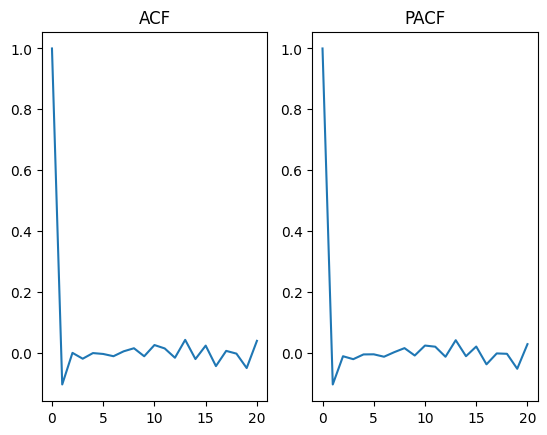

In [13]:
lag_acf = acf(data['diff'].dropna(), nlags=20)
lag_pacf = pacf(data['diff'].dropna(), nlags=20)

plt.subplot(121)
plt.plot(lag_acf)
plt.title('ACF')
plt.subplot(122)
plt.plot(lag_pacf)
plt.title('PACF')
plt.show()

In [14]:
model = ARIMA(data['USDBRL=X'], order=(5, 1, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               USDBRL=X   No. Observations:                 5228
Model:                 ARIMA(5, 1, 0)   Log Likelihood                9352.748
Date:                Fri, 05 Sep 2025   AIC                         -18693.496
Time:                        19:28:59   BIC                         -18654.127
Sample:                             0   HQIC                        -18679.729
                               - 5228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1062      0.007    -14.266      0.000      -0.121      -0.092
ar.L2         -0.0142      0.009     -1.518      0.129      -0.033       0.004
ar.L3         -0.0221      0.010     -2.324      0.0

In [18]:
forecast = model.forecast(steps=7)
print('7-Day Forecast: ', forecast)

7-Day Forecast:  5228    5.463550
5229    5.463279
5230    5.462582
5231    5.462521
5232    5.462411
5233    5.462460
5234    5.462463
Name: predicted_mean, dtype: float64


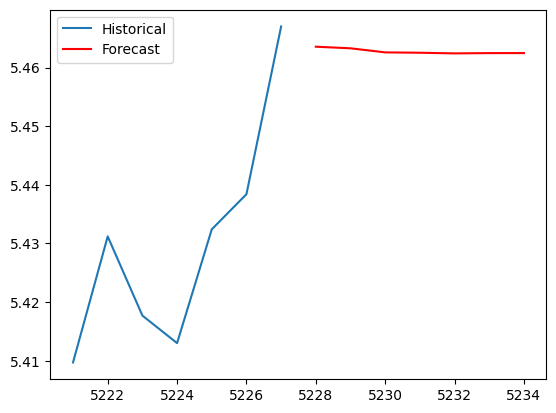

In [ ]:
data['USDBRL=X'].tail(7).plot(label='Historical')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()